In [1]:
import asyncio
import itertools
import logging
import random
import nest_asyncio

nest_asyncio.apply()  # must be run at the start of every notebook to patch the event loop to allow nesting, eg. so we can run asyncio.run from within a notebook.

In [2]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union

In [3]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import (
    run_runners,
    set_default_path,
    set_up_common_builder,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv("NUPLAN_HYDRA_CONFIG_PATH", "config/simulation")

if os.environ.get("NUPLAN_HYDRA_CONFIG_PATH") is not None:
    CONFIG_PATH = os.path.join("../../../../", CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != "simulation":
    CONFIG_PATH = os.path.join(CONFIG_PATH, "simulation")
CONFIG_NAME = "default_simulation"

In [4]:
%pwd

'/host_home/Repos/nuplan-devkit/experiments'

In [22]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(
    os.getenv("NUPLAN_TUTORIAL_PATH", ""), "../nuplan/planning/script"
)
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

# Create a temporary directory to store the simulation artifacts

DATASET_PARAMS = [
    "scenario_builder=nuplan_mini",  # use nuplan mini database (2.5h of 8 autolabeled logs in Las Vegas)
    "scenario_filter=all_scenarios",  # initially select all scenarios in the database
    "scenario_filter.scenario_types=[near_multiple_vehicles, on_pickup_dropoff, starting_unprotected_cross_turn, high_magnitude_jerk]",  # select scenario types
    "scenario_filter.num_scenarios_per_type=5",  # use 5 scenarios per scenario type
    #     'scenario_filter=one_continuous_log',  # simulate only one log
    #     "scenario_filter.log_names=['2021.06.14.16.48.02_veh-12_04057_04438']",
    #     'scenario_filter.limit_total_scenarios=1',  # use 1 total scenarios
]
ckpt_dir = "/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt"
#'/home/sacardoz/checkpoints/urbandriver_checkpoint.ckpt'
# "/home/sacardoz/tutorial_vector_framework/training_simple_vector_experiment/train_default_simple_vector/2023.11.23.09.55.21/best_model/epoch.ckpt"
# "/home/sacardoz/training_raster_experiment/train_default_raster/2023.11.23.07.36.36/best_model/epoch.ckpt"
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        "+simulation=closed_loop_reactive_agents",
        #'model=pgm_hybrid_model',
        "planner=pdm_hybrid_planner",
        f"planner.pdm_hybrid_planner.checkpoint_path={ckpt_dir}",
        #'planner.ml_planner.model_config=${model}',
        # f'planner.ml_planner.checkpoint_path={ckpt_dir}',
        # f'observation=idm_agents_observation',
        #'observation.model_config=${model}',
        # f'observation.checkpoint_path={ckpt_dir}',
        "worker=sequential",
        "+occlusion=true",
        "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
    ],
)

output_folder = cfg.output_dir

default_simulation


# The following set of cells holds the files nescesary to start and run the simulation

## simulations_runner.py

In [23]:
from __future__ import annotations

import logging
import time
from typing import Any, Callable, List

from nuplan.planning.scenario_builder.abstract_scenario import AbstractScenario
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner
from nuplan.planning.simulation.runner.abstract_runner import AbstractRunner
from nuplan.planning.simulation.runner.runner_report import RunnerReport
from nuplan.planning.simulation.simulation import Simulation

logger = logging.getLogger(__name__)


def for_each(fn: Callable[[Any], Any], items: List[Any]) -> None:
    """
    Call function on every item in items
    :param fn: function to be called fn(item)
    :param items: list of items
    """
    for item in items:
        fn(item)


class SimulationRunner(AbstractRunner):
    """
    Manager which executes multiple simulations with the same planner
    """

    def __init__(self, simulation: Simulation, planner: AbstractPlanner):
        """
        Initialize the simulations manager
        :param simulation: Simulation which will be executed
        :param planner: to be used to compute the desired ego's trajectory
        """
        self._simulation = simulation
        self._planner = planner

    def _initialize(self) -> None:
        """
        Initialize the planner
        """
        # Execute specific callback
        self._simulation.callback.on_initialization_start(
            self._simulation.setup, self.planner
        )

        # Initialize Planner
        self.planner.initialize(self._simulation.initialize())

        # Execute specific callback
        self._simulation.callback.on_initialization_end(
            self._simulation.setup, self.planner
        )

    @property
    def planner(self) -> AbstractPlanner:
        """
        :return: Planner used by the SimulationRunner
        """
        return self._planner

    @property
    def simulation(self) -> Simulation:
        """
        :return: Simulation used by the SimulationRunner
        """
        return self._simulation

    @property
    def scenario(self) -> AbstractScenario:
        """
        :return: Get the scenario relative to the simulation.
        """
        return self.simulation.scenario

    def run(self) -> RunnerReport:
        """
        Run through all simulations. The steps of execution follow:
         - Initialize all planners
         - Step through simulations until there no running simulation
        :return: List of SimulationReports containing the results of each simulation
        """
        start_time = time.perf_counter()

        # Initialize reports for all the simulations that will run
        report = RunnerReport(
            succeeded=True,
            error_message=None,
            start_time=start_time,
            end_time=None,
            planner_report=None,
            scenario_name=self._simulation.scenario.scenario_name,
            planner_name=self.planner.name(),
            log_name=self._simulation.scenario.log_name,
        )

        # Execute specific callback
        self.simulation.callback.on_simulation_start(self.simulation.setup)

        # Initialize all simulations
        self._initialize()

        while self.simulation.is_simulation_running():
            # Execute specific callback
            self.simulation.callback.on_step_start(self.simulation.setup, self.planner)

            # Perform step
            planner_input = self._simulation.get_planner_input()
            logger.debug("Simulation iterations: %s" % planner_input.iteration.index)

            # Execute specific callback
            self._simulation.callback.on_planner_start(
                self.simulation.setup, self.planner
            )

            # Plan path based on all planner's inputs
            trajectory = self.planner.compute_trajectory(planner_input)

            # Propagate simulation based on planner trajectory
            self._simulation.callback.on_planner_end(
                self.simulation.setup, self.planner, trajectory
            )
            self.simulation.propagate(trajectory)

            # Execute specific callback
            self.simulation.callback.on_step_end(
                self.simulation.setup, self.planner, self.simulation.history.last()
            )

            # Store reports for simulations which just finished running
            current_time = time.perf_counter()
            if not self.simulation.is_simulation_running():
                report.end_time = current_time

        # Execute specific callback
        self.simulation.callback.on_simulation_end(
            self.simulation.setup, self.planner, self.simulation.history
        )

        planner_report = self.planner.generate_planner_report()
        report.planner_report = planner_report

        return report

## executor.py

In [24]:
import concurrent.futures
import logging
import time
import traceback
from typing import Dict, List, Optional, Tuple, Union

from nuplan.planning.simulation.callback.metric_callback import MetricCallback
from nuplan.planning.simulation.callback.simulation_log_callback import (
    SimulationLogCallback,
)
from nuplan.planning.simulation.runner.abstract_runner import AbstractRunner
from nuplan.planning.simulation.runner.runner_report import RunnerReport

# from nuplan.planning.simulation.runner.simulations_runner import SimulationRunner
from nuplan.planning.utils.multithreading.worker_pool import Task, WorkerPool

logger = logging.getLogger(__name__)


def run_simulation(
    sim_runner: AbstractRunner, exit_on_failure: bool = False
) -> RunnerReport:
    """
    Proxy for calling simulation.
    :param sim_runner: A simulation runner which will execute all batched simulations.
    :param exit_on_failure: If true, raises an exception when the simulation fails.
    :return report for the simulation.
    """
    # Store start time so that if the simulations fail, we know how long they ran for
    start_time = time.perf_counter()

    try:
        return sim_runner.run()
    except Exception as e:
        error = traceback.format_exc()

        # Print to the terminal
        logger.warning("----------- Simulation failed: with the following trace:")
        traceback.print_exc()
        logger.warning(f"Simulation failed with error:\n {e}")

        # Log the failed scenario log/tokens
        failed_scenarios = (
            f"[{sim_runner.scenario.log_name}, {sim_runner.scenario.scenario_name}]\n"
        )
        logger.warning(f"\nFailed simulation [log,token]:\n {failed_scenarios}")

        logger.warning("----------- Simulation failed!")

        # Fail if desired
        if exit_on_failure:
            raise RuntimeError("Simulation failed")

        end_time = time.perf_counter()
        report = RunnerReport(
            succeeded=False,
            error_message=error,
            start_time=start_time,
            end_time=end_time,
            planner_report=None,
            scenario_name=sim_runner.scenario.scenario_name,
            planner_name=sim_runner.planner.name(),
            log_name=sim_runner.scenario.log_name,
        )

        return report


def execute_runners(
    runners: List[AbstractRunner],
    worker: WorkerPool,
    num_gpus: Optional[Union[int, float]],
    num_cpus: Optional[int],
    exit_on_failure: bool = False,
    verbose: bool = False,
) -> List[RunnerReport]:
    """
    Execute multiple simulation runners or metric runners.
    :param runners: A list of simulations to be run.
    :param worker: for submitting tasks.
    :param num_gpus: if None, no GPU will be used, otherwise number (also fractional) of GPU used per simulation.
    :param num_cpus: if None, all available CPU threads are used, otherwise number of threads used.
    :param exit_on_failure: If true, raises an exception when the simulation fails.
    """
    # Validating
    assert len(runners) > 0, "No scenarios found to simulate!"

    # Start simulations
    number_of_sims = len(runners)
    logger.info(
        f"Starting {number_of_sims} simulations using {worker.__class__.__name__}!"
    )
    print("about to start all the runners")
    reports: List[RunnerReport] = worker.map(
        Task(fn=run_simulation, num_gpus=num_gpus, num_cpus=num_cpus),
        runners,
        exit_on_failure,
        verbose=verbose,
    )
    # Store the results in a dictionary so we can easily store error tracebacks in the next step, if needed
    results: Dict[Tuple[str, str, str], RunnerReport] = {
        (report.scenario_name, report.planner_name, report.log_name): report
        for report in reports
    }

    # Iterate over runners, finding the callbacks which may have run asynchronously, and gathering their results
    simulations_runners = (
        runner for runner in runners if isinstance(runner, SimulationRunner)
    )
    relevant_simulations = (
        (runner.simulation, runner) for runner in simulations_runners
    )
    callback_futures_lists = (
        (callback.futures, simulation, runner)
        for (simulation, runner) in relevant_simulations
        for callback in simulation.callback.callbacks
        if isinstance(callback, MetricCallback)
        or isinstance(callback, SimulationLogCallback)
    )
    callback_futures_map = {
        future: (
            simulation.scenario.scenario_name,
            runner.planner.name(),
            simulation.scenario.log_name,
        )
        for (futures, simulation, runner) in callback_futures_lists
        for future in futures
    }
    for future in concurrent.futures.as_completed(callback_futures_map.keys()):
        try:
            future.result()
        except Exception:
            error_message = traceback.format_exc()
            runner_report = results[callback_futures_map[future]]
            runner_report.error_message = error_message
            runner_report.succeeded = False
            runner_report.end_time = time.perf_counter()

    # Notify user about the result of simulations
    failed_simulations = str()
    number_of_successful = 0
    runner_reports: List[RunnerReport] = list(results.values())
    for result in runner_reports:
        if result.succeeded:
            number_of_successful += 1
        else:
            logger.warning("Failed Simulation.\n '%s'", result.error_message)
            failed_simulations += f"[{result.log_name}, {result.scenario_name}] \n"

    number_of_failures = number_of_sims - number_of_successful
    logger.info(f"Number of successful simulations: {number_of_successful}")
    logger.info(f"Number of failed simulations: {number_of_failures}")

    # Print out all failed simulation unique identifier
    if number_of_failures > 0:
        logger.info(f"Failed simulations [log, token]:\n{failed_simulations}")

    return runner_reports

## utils.py

In [25]:
import logging
import os
from dataclasses import dataclass
from pathlib import Path
from typing import List

import pandas as pd
from omegaconf import DictConfig

from nuplan.common.utils.file_backed_barrier import distributed_sync
from nuplan.common.utils.io_utils import safe_path_to_string
from nuplan.planning.script.builders.folder_builder import (
    build_simulation_experiment_folder,
)
from nuplan.planning.script.builders.logging_builder import build_logger
from nuplan.planning.script.builders.main_callback_builder import (
    build_main_multi_callback,
)
from nuplan.planning.script.builders.utils.utils_config import (
    update_config_for_simulation,
)
from nuplan.planning.script.builders.worker_pool_builder import build_worker
from nuplan.planning.simulation.main_callback.multi_main_callback import (
    MultiMainCallback,
)
from nuplan.planning.simulation.runner.abstract_runner import AbstractRunner

# from nuplan.planning.simulation.runner.executor import execute_runners
from nuplan.planning.simulation.runner.runner_report import RunnerReport
from nuplan.planning.training.callbacks.profile_callback import ProfileCallback
from nuplan.planning.utils.multithreading.worker_pool import WorkerPool

logger = logging.getLogger(__name__)

DEFAULT_DATA_ROOT = os.path.expanduser("~/nuplan/dataset")
DEFAULT_EXP_ROOT = os.path.expanduser("~/nuplan/exp")


@dataclass
class CommonBuilder:
    """Common builder data."""

    worker: WorkerPool
    multi_main_callback: MultiMainCallback
    output_dir: Path
    profiler: ProfileCallback


def set_default_path() -> None:
    """
    This function sets the default paths as environment variables if none are set.
    These can then be used by Hydra, unless the user overwrites them from the command line.
    """
    if "NUPLAN_DATA_ROOT" not in os.environ:
        logger.info(f"Setting default NUPLAN_DATA_ROOT: {DEFAULT_DATA_ROOT}")
        os.environ["NUPLAN_DATA_ROOT"] = DEFAULT_DATA_ROOT

    if "NUPLAN_EXP_ROOT" not in os.environ:
        logger.info(f"Setting default NUPLAN_EXP_ROOT: {DEFAULT_EXP_ROOT}")
        os.environ["NUPLAN_EXP_ROOT"] = DEFAULT_EXP_ROOT


def save_runner_reports(
    reports: List[RunnerReport], output_dir: Path, report_name: str
) -> None:
    """
    Save runner reports to a parquet file in the output directory.
    Output directory can be local or s3.
    :param reports: Runner reports returned from each simulation.
    :param output_dir: Output directory to save the report.
    :param report_name: Report name.
    """
    report_dicts = []
    for report in map(lambda x: x.__dict__, reports):  # type: ignore
        if (planner_report := report["planner_report"]) is not None:
            planner_report_statistics = planner_report.compute_summary_statistics()
            del report["planner_report"]
            report.update(planner_report_statistics)
        report_dicts.append(report)
    df = pd.DataFrame(report_dicts)
    df["duration"] = df["end_time"] - df["start_time"]

    save_path = output_dir / report_name
    df.to_parquet(safe_path_to_string(save_path))
    logger.info(f"Saved runner reports to {save_path}")


def set_up_common_builder(cfg: DictConfig, profiler_name: str) -> CommonBuilder:
    """
    Set up a common builder when running simulations.
    :param cfg: Hydra configuration.
    :param profiler_name: Profiler name.
    :return A data classes with common builders.
    """
    # Build multi main callback
    multi_main_callback = build_main_multi_callback(cfg)

    # After run_simulation start
    multi_main_callback.on_run_simulation_start()

    # Update and override configs for simulation
    update_config_for_simulation(cfg=cfg)

    # Configure logger
    build_logger(cfg)

    # Construct builder
    worker = build_worker(cfg)

    # Create output storage folder
    build_simulation_experiment_folder(cfg=cfg)

    # Simulation Callbacks
    output_dir = Path(cfg.output_dir)

    # Create profiler if enabled
    profiler = None
    if cfg.enable_profiling:
        logger.info("Profiler is enabled!")
        profiler = ProfileCallback(output_dir=output_dir)

    if profiler:
        # Profile the simulation construction
        profiler.start_profiler(profiler_name)

    return CommonBuilder(
        worker=worker,
        multi_main_callback=multi_main_callback,
        output_dir=output_dir,
        profiler=profiler,
    )


def run_runners(
    runners: List[AbstractRunner],
    common_builder: CommonBuilder,
    profiler_name: str,
    cfg: DictConfig,
) -> None:
    """
    Run a list of runners.
    :param runners: A list of runners.
    :param common_builder: Common builder.
    :param profiler_name: Profiler name.
    :param cfg: Hydra config.
    """
    assert len(runners) > 0, "No scenarios found to simulate!"
    if common_builder.profiler:
        # Start simulation running profiling
        common_builder.profiler.start_profiler(profiler_name)

    logger.info("Executing runners...")
    reports = execute_runners(
        runners=runners,
        worker=common_builder.worker,
        num_gpus=cfg.number_of_gpus_allocated_per_simulation,
        num_cpus=cfg.number_of_cpus_allocated_per_simulation,
        exit_on_failure=cfg.exit_on_failure,
        verbose=cfg.verbose,
    )
    logger.info("Finished executing runners!")

    # Save RunnerReports as parquet file
    save_runner_reports(reports, common_builder.output_dir, cfg.runner_report_file)

    # Sync up nodes when running distributed simulation
    distributed_sync(
        Path(cfg.output_dir / Path("barrier")), cfg.distributed_timeout_seconds
    )

    # Only run on_run_simulation_end callbacks on master node
    if int(os.environ.get("NODE_RANK", 0)) == 0:
        common_builder.multi_main_callback.on_run_simulation_end()

    # Save profiler
    if common_builder.profiler:
        common_builder.profiler.save_profiler(profiler_name)

## simulation_builder.py

In [26]:
import logging
import os
from typing import List, Optional

from hydra.utils import instantiate
from omegaconf import DictConfig

from nuplan.common.utils.distributed_scenario_filter import (
    DistributedMode,
    DistributedScenarioFilter,
)
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_builder import (
    NuPlanScenarioBuilder,
)
from nuplan.planning.script.builders.metric_builder import build_metrics_engines
from nuplan.planning.script.builders.observation_builder import build_observations
from nuplan.planning.script.builders.occlusion_manager_builder import (
    build_occlusion_manager,
)
from nuplan.planning.script.builders.planner_builder import build_planners
from nuplan.planning.script.builders.utils.utils_type import is_target_type
from nuplan.planning.simulation.callback.abstract_callback import AbstractCallback
from nuplan.planning.simulation.callback.metric_callback import MetricCallback
from nuplan.planning.simulation.callback.multi_callback import MultiCallback
from nuplan.planning.simulation.controller.abstract_controller import (
    AbstractEgoController,
)
from nuplan.planning.simulation.observation.abstract_observation import (
    AbstractObservation,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

# from nuplan.planning.simulation.runner.simulations_runner import SimulationRunner
from nuplan.planning.simulation.simulation import Simulation
from nuplan.planning.simulation.simulation_setup import SimulationSetup
from nuplan.planning.simulation.simulation_time_controller.abstract_simulation_time_controller import (
    AbstractSimulationTimeController,
)
from nuplan.planning.utils.multithreading.worker_pool import WorkerPool

logger = logging.getLogger(__name__)


def build_simulations(
    cfg: DictConfig,
    worker: WorkerPool,
    callbacks: List[AbstractCallback],
    callbacks_worker: Optional[WorkerPool] = None,
    pre_built_planners: Optional[List[AbstractPlanner]] = None,
) -> List[SimulationRunner]:
    """
    Build simulations.
    :param cfg: DictConfig. Configuration that is used to run the experiment.
    :param callbacks: Callbacks for simulation.
    :param worker: Worker for job execution.
    :param callbacks_worker: worker pool to use for callbacks from sim
    :param pre_built_planners: List of pre-built planners to run in simulation.
    :return A dict of simulation engines with challenge names.
    """
    logger.info("Building simulations...")

    # Create Simulation object container
    simulations = list()

    # Retrieve scenarios
    logger.info("Extracting scenarios...")

    # Only allow simulation with NuPlanScenarioBuilder except when the NUPLAN_SIMULATION_ALLOW_ANY_BUILDER environment variable is set to a non-zero value.
    if not int(
        os.environ.get("NUPLAN_SIMULATION_ALLOW_ANY_BUILDER", "0")
    ) and not is_target_type(cfg.scenario_builder, NuPlanScenarioBuilder):
        raise ValueError(
            f"Simulation framework only runs with NuPlanScenarioBuilder. Got {cfg.scenario_builder}"
        )

    scenario_filter = DistributedScenarioFilter(
        cfg=cfg,
        worker=worker,
        node_rank=int(os.environ.get("NODE_RANK", 0)),
        num_nodes=int(os.environ.get("NUM_NODES", 1)),
        synchronization_path=cfg.output_dir,
        timeout_seconds=cfg.distributed_timeout_seconds,
        distributed_mode=DistributedMode[cfg.distributed_mode],
    )
    scenarios = scenario_filter.get_scenarios()

    metric_engines_map = {}
    if cfg.run_metric:
        logger.info("Building metric engines...")
        metric_engines_map = build_metrics_engines(cfg=cfg, scenarios=scenarios)
        logger.info("Building metric engines...DONE")
    else:
        logger.info("Metric engine is disable")

    logger.info("Building simulations from %d scenarios...", len(scenarios))

    # Build a metric metadata file
    for scenario in scenarios:

        # Build planners
        if pre_built_planners is None:
            if "planner" not in cfg.keys():
                raise KeyError(
                    'Planner not specified in config. Please specify a planner using "planner" field.'
                )

            planners = build_planners(cfg.planner, scenario)
        else:
            planners = pre_built_planners

        for planner in planners:
            # Ego Controller
            ego_controller: AbstractEgoController = instantiate(
                cfg.ego_controller, scenario=scenario
            )

            # Simulation Manager
            simulation_time_controller: AbstractSimulationTimeController = instantiate(
                cfg.simulation_time_controller, scenario=scenario
            )

            # Perception
            observations: AbstractObservation = build_observations(
                cfg.observation, scenario=scenario
            )

            # Occlusions
            if "occlusion_cfg" in cfg.keys() and cfg.occlusion_cfg.occlusion:
                occlusion_manager: AbstractOcclusionManager = build_occlusion_manager(
                    cfg.occlusion_cfg, scenario=scenario
                )
            else:
                occlusion_manager = None

            # Metric Engine
            metric_engine = metric_engines_map.get(scenario.scenario_type, None)
            if metric_engine is not None:
                stateful_callbacks = [
                    MetricCallback(
                        metric_engine=metric_engine, worker_pool=callbacks_worker
                    )
                ]
            else:
                stateful_callbacks = []

            if "simulation_log_callback" in cfg.callback:
                stateful_callbacks.append(
                    instantiate(
                        cfg.callback["simulation_log_callback"],
                        worker_pool=callbacks_worker,
                    )
                )

            # Construct simulation and manager
            simulation_setup = SimulationSetup(
                time_controller=simulation_time_controller,
                observations=observations,
                ego_controller=ego_controller,
                occlusion_manager=occlusion_manager,
                scenario=scenario,
            )

            simulation = Simulation(
                simulation_setup=simulation_setup,
                callback=MultiCallback(callbacks + stateful_callbacks),
                simulation_history_buffer_duration=cfg.simulation_history_buffer_duration,
            )
            simulations.append(SimulationRunner(simulation, planner))

    logger.info("Building simulations...DONE!")
    return simulations

## run_simulation.py

In [27]:
import logging
import os
from pathlib import Path
from shutil import rmtree
from typing import List, Optional, Union

import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path

# from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)

# from utils import run_runners, set_default_path, set_up_common_builder
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv("NUPLAN_HYDRA_CONFIG_PATH", "config/simulation")

if os.environ.get("NUPLAN_HYDRA_CONFIG_PATH") is not None:
    CONFIG_PATH = os.path.join("../../../../", CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != "simulation":
    CONFIG_PATH = os.path.join(CONFIG_PATH, "simulation")
CONFIG_NAME = "default_simulation"


def run_simulation_main(
    cfg: DictConfig,
    planners: Optional[Union[AbstractPlanner, List[AbstractPlanner]]] = None,
) -> None:
    """
    Execute all available challenges simultaneously on the same scenario. Helper function for main to allow planner to
    be specified via config or directly passed as argument.
    :param cfg: Configuration that is used to run the experiment.
        Already contains the changes merged from the experiment's config to default config.
    :param planners: Pre-built planner(s) to run in simulation. Can either be a single planner or list of planners.
    """
    # Fix random seed
    pl.seed_everything(cfg.seed, workers=True)

    profiler_name = "building_simulation"
    common_builder = set_up_common_builder(cfg=cfg, profiler_name=profiler_name)

    # Build simulation callbacks
    callbacks_worker_pool = build_callbacks_worker(cfg)
    callbacks = build_simulation_callbacks(
        cfg=cfg, output_dir=common_builder.output_dir, worker=callbacks_worker_pool
    )

    # Remove planner from config to make sure run_simulation does not receive multiple planner specifications.
    if planners and "planner" in cfg.keys():
        logger.info("Using pre-instantiated planner. Ignoring planner in config")
        OmegaConf.set_struct(cfg, False)
        cfg.pop("planner")
        OmegaConf.set_struct(cfg, True)

    # Construct simulations
    if isinstance(planners, AbstractPlanner):
        planners = [planners]

    runners = build_simulations(
        cfg=cfg,
        callbacks=callbacks,
        worker=common_builder.worker,
        pre_built_planners=planners,
        callbacks_worker=callbacks_worker_pool,
    )

    if common_builder.profiler:
        # Stop simulation construction profiling
        common_builder.profiler.save_profiler(profiler_name)

    logger.info("Running simulation...")
    run_runners(
        runners=runners,
        common_builder=common_builder,
        cfg=cfg,
        profiler_name="running_simulation",
    )
    logger.info("Finished running simulation!")


def clean_up_s3_artifacts() -> None:
    """
    Cleanup lingering s3 artifacts that are written locally.
    This happens because some minor write-to-s3 functionality isn't yet implemented.
    """
    # Lingering artifacts get written locally to a 's3:' directory. Hydra changes
    # the working directory to a subdirectory of this, so we serach the working
    # path for it.
    working_path = os.getcwd()
    s3_dirname = "s3:"
    s3_ind = working_path.find(s3_dirname)
    if s3_ind != -1:
        local_s3_path = working_path[: working_path.find(s3_dirname) + len(s3_dirname)]
        rmtree(local_s3_path)


@hydra.main(config_path=CONFIG_PATH, config_name=CONFIG_NAME)
def main(cfg: DictConfig) -> None:
    """
    Execute all available challenges simultaneously on the same scenario. Calls run_simulation to allow planner to
    be specified via config or directly passed as argument.
    :param cfg: Configuration that is used to run the experiment.
        Already contains the changes merged from the experiment's config to default config.
    """
    assert (
        cfg.simulation_log_main_path is None
    ), "Simulation_log_main_path must not be set when running simulation."
    # Execute simulation with preconfigured planner(s).
    run_simulation_main(cfg=cfg)


#     if is_s3_path(Path(cfg.output_dir)):
#         clean_up_s3_artifacts()


# if __name__ == '__main__':
#     main()

# Now we can run with the following

In [28]:
# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main(cfg)

# Simple simulation folder for visualization in nuBoard
simple_simulation_folder = cfg.output_dir

Global seed set to 0


2023-12-06 02:53:02,337 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2023-12-06 02:53:02,337 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2023-12-06 02:53:02,362 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2023-12-06 02:53:02,362 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2023-12-06 02:53:02,532 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-12-06 02:53:02,532 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-12-06 02:53:02,533 INFO {/home/ehdykhne/Repos/nuplan-de

KeyboardInterrupt: 

Global seed set to 0


2023-12-06 02:31:37,952 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:20}  Building MultiMainCallback...
2023-12-06 02:31:37,958 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/builders/main_callback_builder.py:35}  Building MultiMainCallback: 4...DONE!
2023-12-06 02:31:38,122 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-12-06 02:31:38,122 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2023-12-06 02:31:38,123 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: Sequential
2023-12-06 02:31:38,123 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: Sequential
2023-12-06 02:31:38,123 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/utils/multithread

2023-12-06 02:32:37,388 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 1
2023-12-06 02:32:37,388 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:127}  Number of successful simulations: 1
2023-12-06 02:32:37,388 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2023-12-06 02:32:37,388 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:128}  Number of failed simulations: 0
2023-12-06 02:32:37,388 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2023-12-06 02:32:37,388 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2023-12-06 02:32:37,394 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to /home/eh

Rendering histograms:   5%|▍         | 1/21 [00:00<00:05,  3.84it/s]

2023-12-06 02:32:37,714 INFO {/opt/conda/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-06 02:32:37,714 INFO {/opt/conda/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-06 02:32:37,717 INFO {/opt/conda/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-06 02:32:37,717 INFO {/opt/conda/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list

Rendering histograms:  62%|██████▏   | 13/21 [00:01<00:00,  9.57it/s]

2023-12-06 02:32:39,361 INFO {/opt/conda/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-06 02:32:39,361 INFO {/opt/conda/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-06 02:32:39,366 INFO {/opt/conda/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-06 02:32:39,366 INFO {/opt/conda/lib/python3.9/site-packages/matplotlib/category.py:223}  Using categorical units to plot a list

Rendering histograms: 100%|██████████| 21/21 [00:02<00:00,  7.12it/s]


2023-12-06 02:32:42,303 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:04 [HH:MM:SS]
2023-12-06 02:32:42,303 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:04 [HH:MM:SS]
2023-12-06 02:32:42,303 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/run_simulation.py:116}  Finished running simulation!
2023-12-06 02:32:42,303 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/run_simulation.py:116}  Finished running simulation!


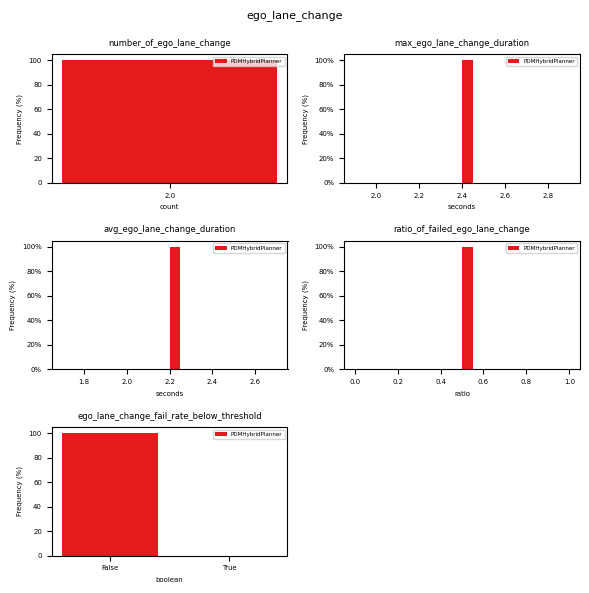

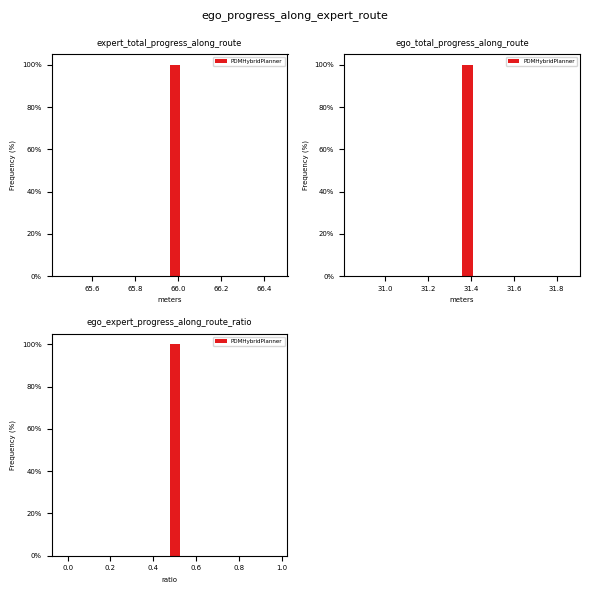

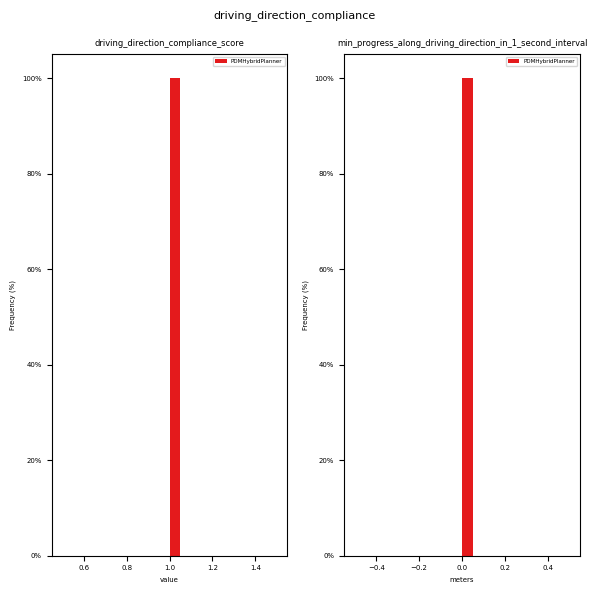

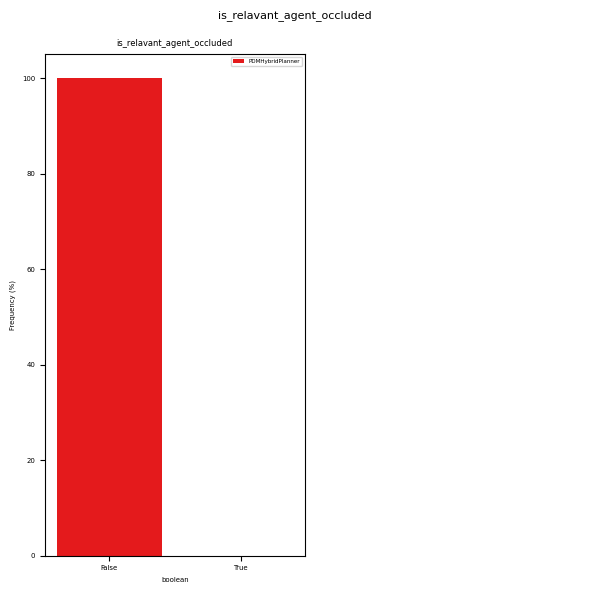

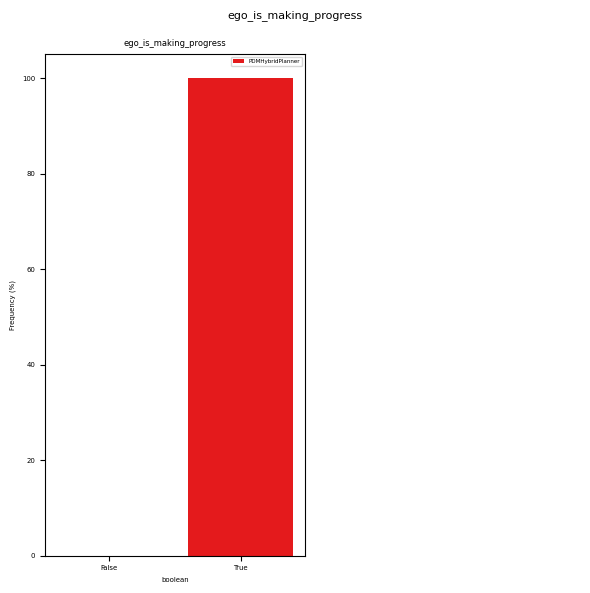

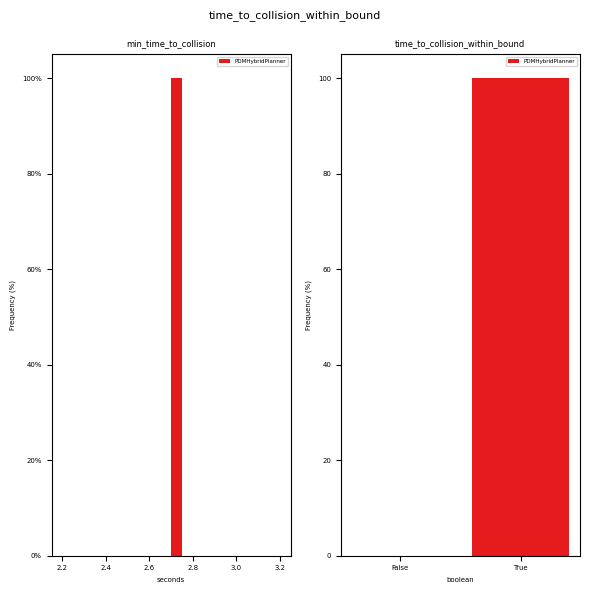

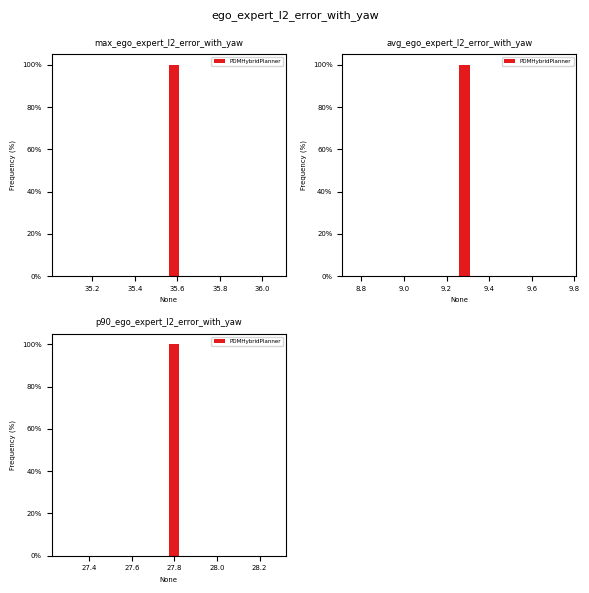

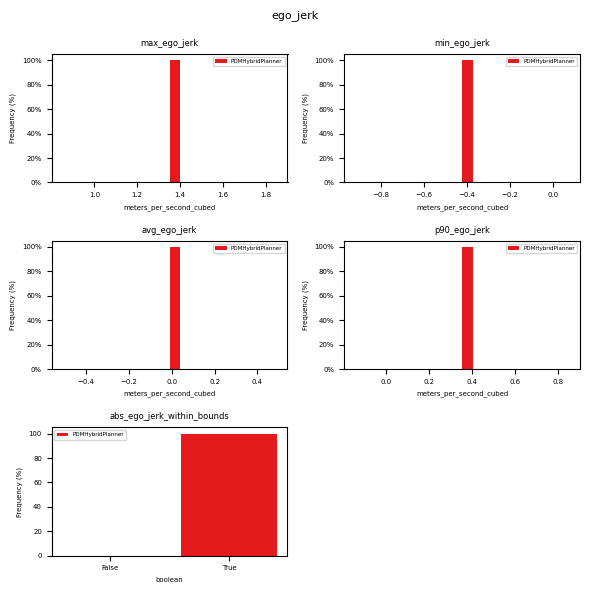

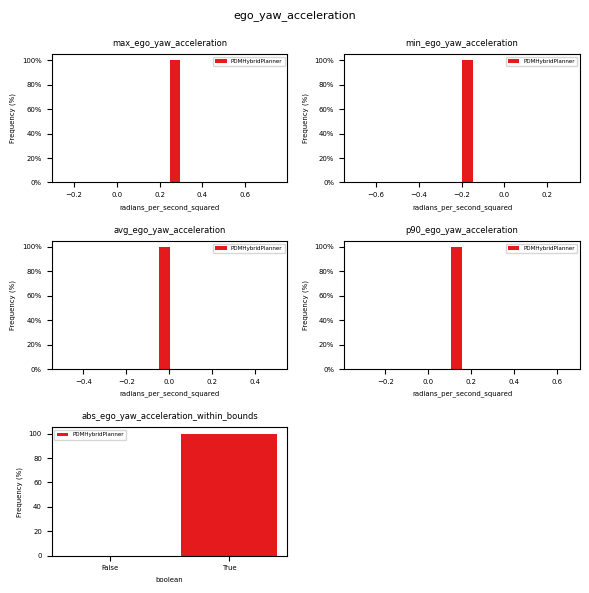

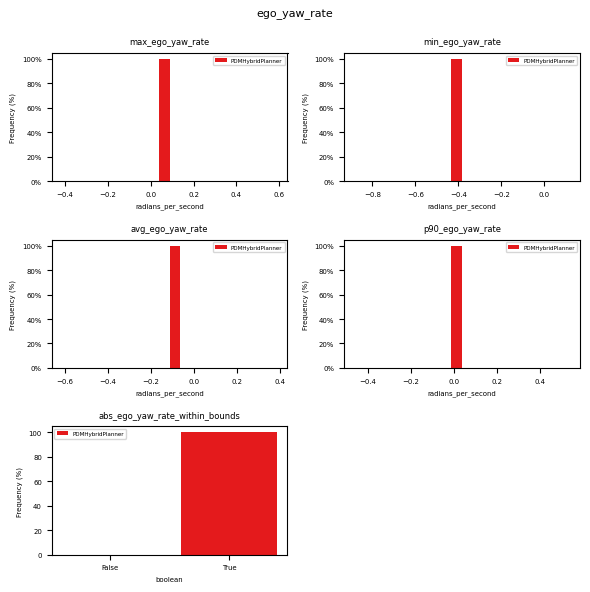

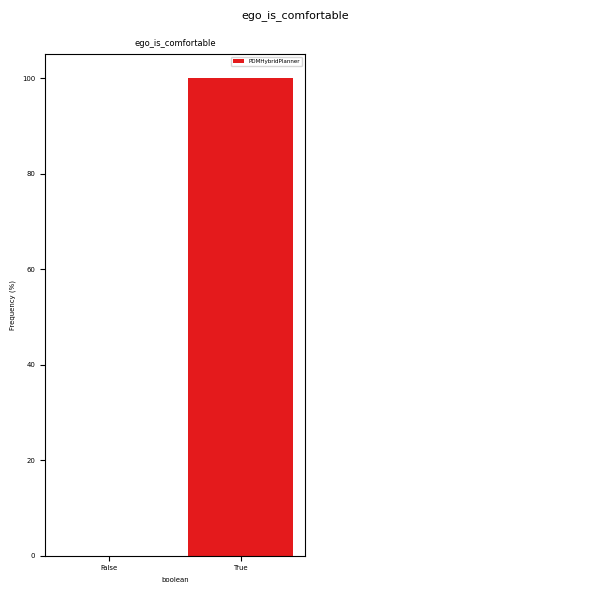

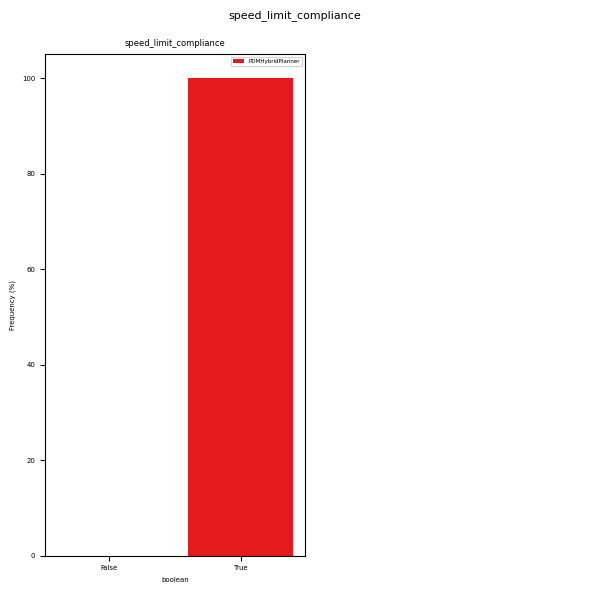

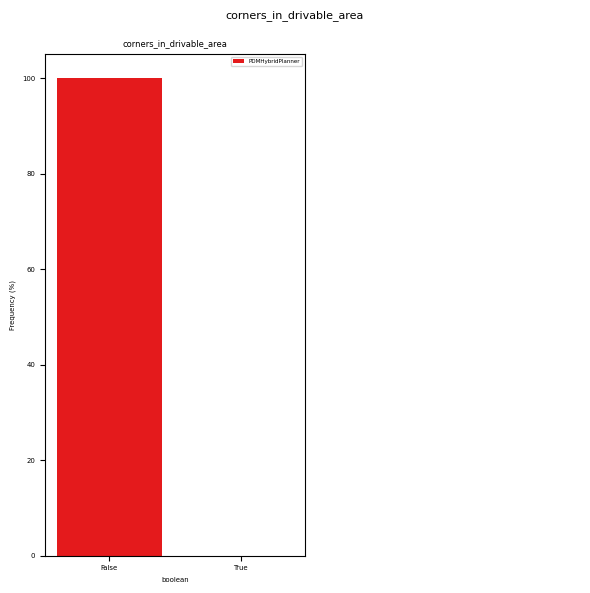

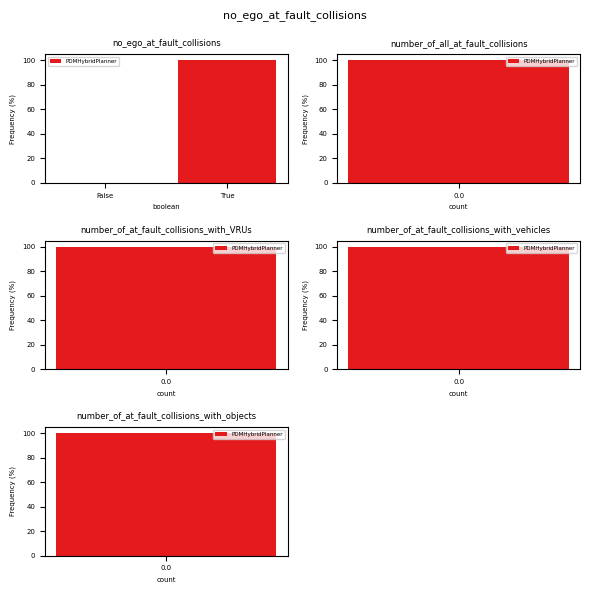

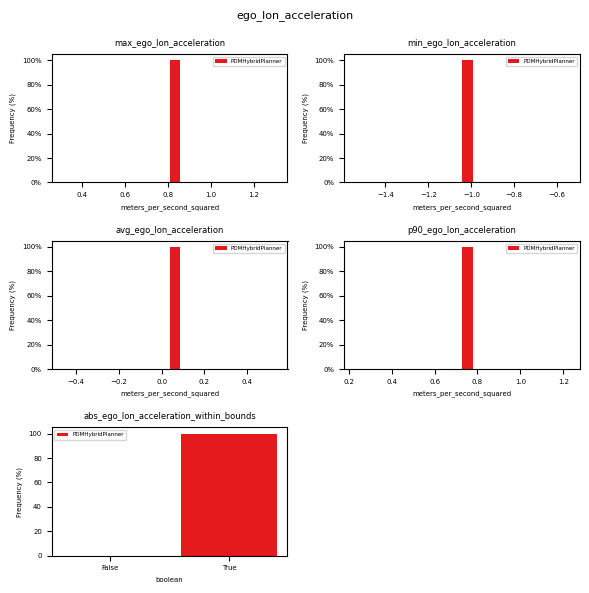

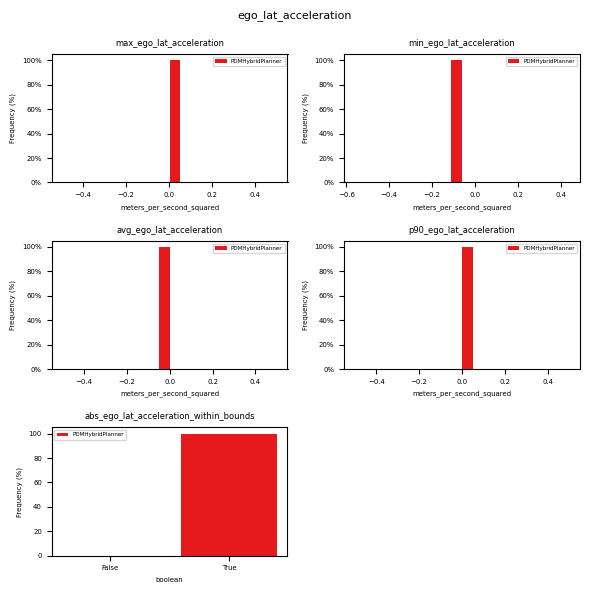

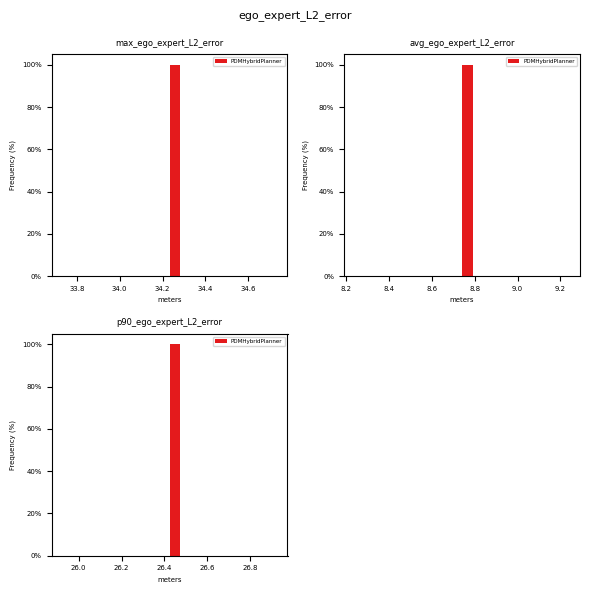

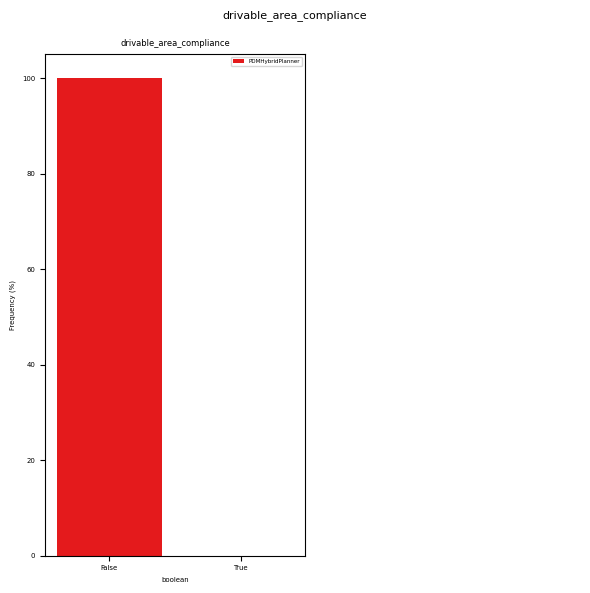

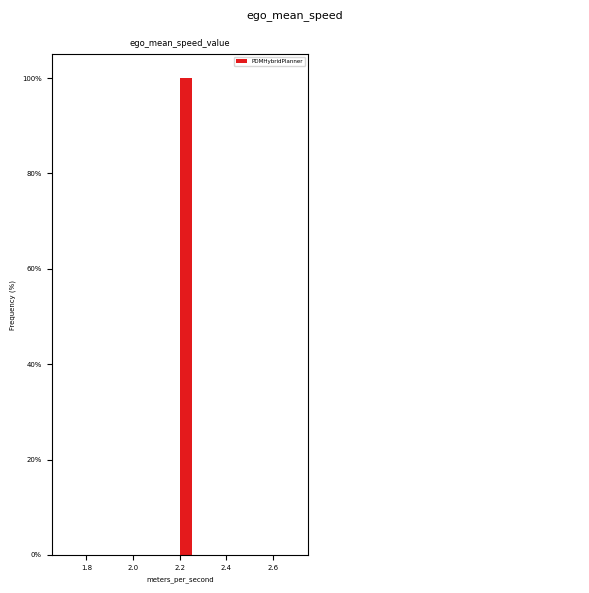

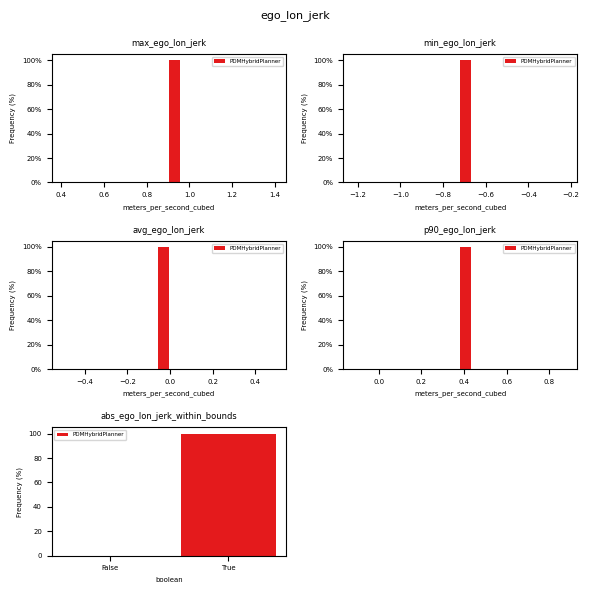

In [15]:
from nuplan.planning.script.run_simulation import main as main_simulation

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg)

## Prepare the nuBoard config

In [19]:
# Location of path with all nuBoard configs
CONFIG_PATH = "../nuplan/planning/script/config/nuboard"
CONFIG_NAME = "default_nuboard"

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(
    config_name=CONFIG_NAME,
    overrides=[
        "scenario_builder=nuplan_mini",  # set the database (same as simulation) used to fetch data for visualization
        f"simulation_path={[output_folder]}",  # nuboard file path(s), if left empty the user can open the file inside nuBoard
    ],
)

## Launch nuBoard (open in new tab - recommended)

In [20]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2023-12-06 02:41:59,781 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-12-06 02:41:59,781 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2023-12-06 02:41:59,792 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-12-06 02:41:59,792 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2023-12-06 02:41:59,793 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2023-12-06 02:41:59,793 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2023-12-

INFO:tornado.access:200 GET / (10.40.117.44) 267.62ms


2023-12-06 02:42:06,039 INFO {/opt/conda/lib/python3.9/site-packages/tornado/web.py:2271}  101 GET /ws (10.40.117.44) 1.62ms
2023-12-06 02:42:06,039 INFO {/opt/conda/lib/python3.9/site-packages/tornado/web.py:2271}  101 GET /ws (10.40.117.44) 1.62ms
2023-12-06 02:42:06,041 INFO {/opt/conda/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2023-12-06 02:42:06,041 INFO {/opt/conda/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2023-12-06 02:42:06,042 INFO {/opt/conda/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created
2023-12-06 02:42:06,042 INFO {/opt/conda/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created


INFO:tornado.access:101 GET /ws (10.40.117.44) 1.62ms


2023-12-06 02:42:06,261 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-12-06 02:42:06,261 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2023-12-06 02:42:06,267 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0007 seconds.
2023-12-06 02:42:06,267 INFO {/home/ehdykhne/Repos/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0007 seconds.
2023-12-06 02:42:06,370 INFO {/opt/conda/lib/python3.9/site-packages/tornado/web.py:2271}  200 GET / (10.40.117.44) 261.77ms
2023-12-06 02:42:06,370 INFO {/opt/conda/lib/python3.9/site-packages/tornado/web.py:2271}  200 GET / (10.40.117.44) 261.77ms


INFO:tornado.access:200 GET / (10.40.117.44) 261.77ms


KeyboardInterrupt: 

In [21]:
from tutorials.utils.tutorial_utils import visualize_history

visualize_history(runner.simulation._history, runner.scenario, bokeh_port=5007)

NameError: name 'runner' is not defined